In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# df must have columns: "year" (int) and "kd" (str, e.g., "Word-KD, Seq-KD")
# Example:
df = pd.read_csv("time.tsv",sep="\t")#columns=["year","kd"])

def plot_kd_timeline(df, year_col="year", kd_col="kd"):
    # Split multi-label cells and explode into rows
    tidy = (
        df.assign(**{kd_col: df[kd_col].str.split(", ")})
          .explode(kd_col)
          .assign(**{kd_col: lambda d: d[kd_col].str.strip()})
    )

    # Count per year per KD type
    counts = (tidy.groupby([year_col, kd_col]).size()
                    .unstack(fill_value=0)
                    .sort_index())

    # Optional: ensure continuous years on the x-axis
    years = pd.RangeIndex(counts.index.min(), counts.index.max() + 1)
    counts = counts.reindex(years, fill_value=0)

    return counts  # returned table of yearly counts by KD type

df = pd.read_csv("time.tsv",sep="\t")#columns=["year","kd"])
df.head()

,year,kd
0,2019,Word-KD
1,2023,Word-KD
2,2022,Word-KD
3,2022,Seq-KD
4,2022,"Word-KD, Seq-KD"


In [30]:
counts = plot_kd_timeline(df)
print(counts)

kd    Feature-based KD  Seq-KD  Word-KD
2016                 0       1        1
2017                 0       2        1
2018                 0       0        1
2019                 1       2        3
2020                 2       9        5
2021                 2      10        7
2022                 0       9        8
2023                 0       9       11
2024                 1      10        3
2025                 3       9        4


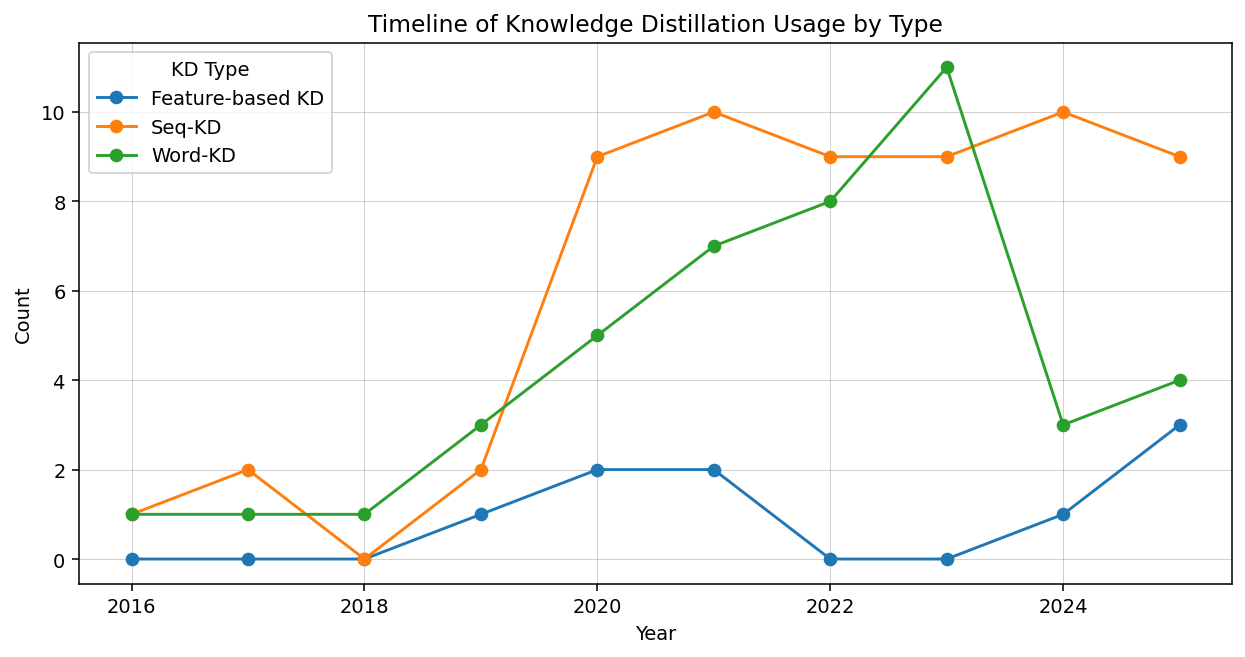

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data (replace with your df)
df = counts

# --- Make sure 'kd' is the year index ---
if "kd" in df.columns:
    df = df.set_index("kd")
df.index = pd.to_numeric(df.index, errors="coerce")
df = df.sort_index()

# --- Columns to plot (all except index) ---
cols = [c for c in df.columns if c not in (None,)]

# --- Plot timeline (no multi-d indexing anywhere) ---
plt.figure(figsize=(9, 4.8))
x = df.index.to_numpy()
for c in cols:
    y = df[c].to_numpy()
    plt.plot(x, y, marker="o", label=c)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Timeline of Knowledge Distillation Usage by Type")
plt.legend(title="KD Type")
plt.grid(True, linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.savefig('timeline.png')

plt.show()


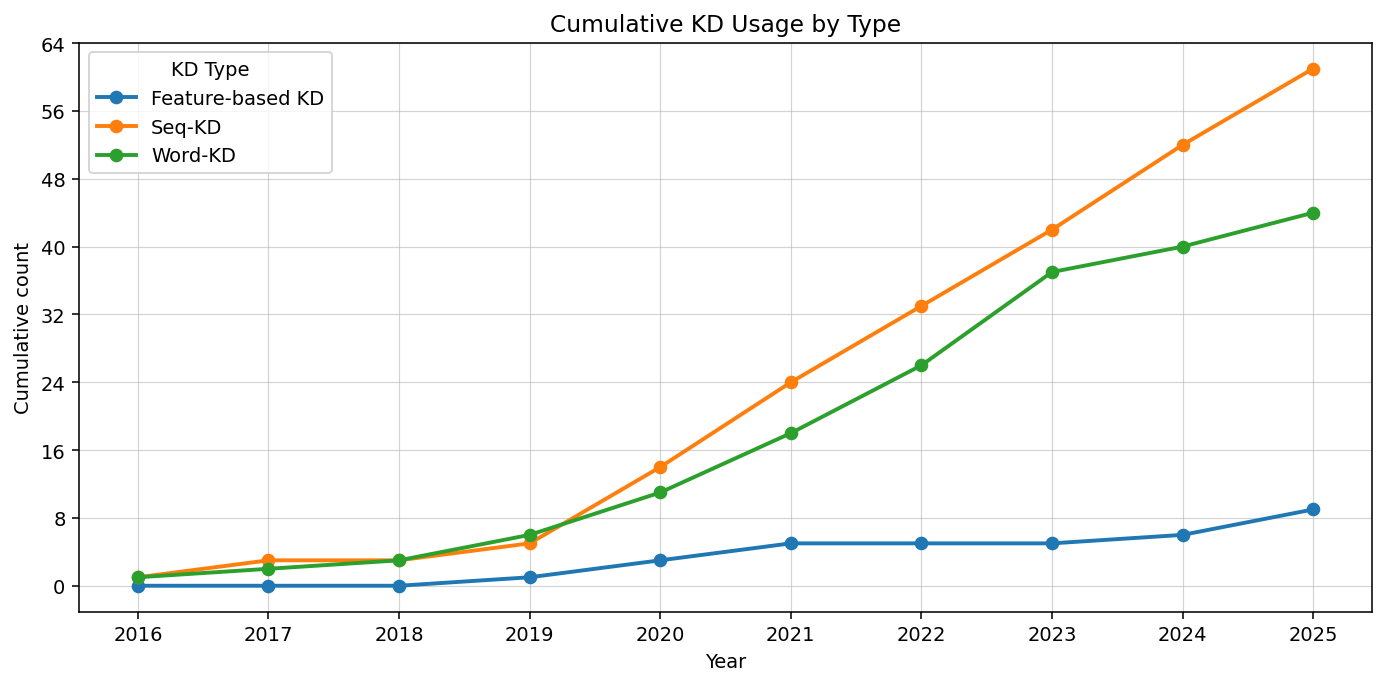

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

df = counts.copy().sort_index()

# Ensure continuous years and plain numeric types
years = range(int(df.index.min()), int(df.index.max()) + 1)
df = df.reindex(years, fill_value=0)

# Make sure columns are numeric, then cumulative
df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
cum = df.cumsum()

# Convert to NumPy for plotting (avoids multi-d indexing error)
x = pd.Index(cum.index, dtype="int64").to_numpy()
fig, ax = plt.subplots(figsize=(10, 5))
for c in cum.columns:
    y = cum[c].to_numpy(dtype="float64")
    ax.plot(x, y, marker="o", linewidth=2, label=c)

ax.set_xlabel("Year")
ax.set_ylabel("Cumulative count")
ax.set_title("Cumulative KD Usage by Type")
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.grid(True, linewidth=0.6, alpha=0.55)
ax.legend(title="KD Type", loc="upper left")
plt.tight_layout()
plt.show()


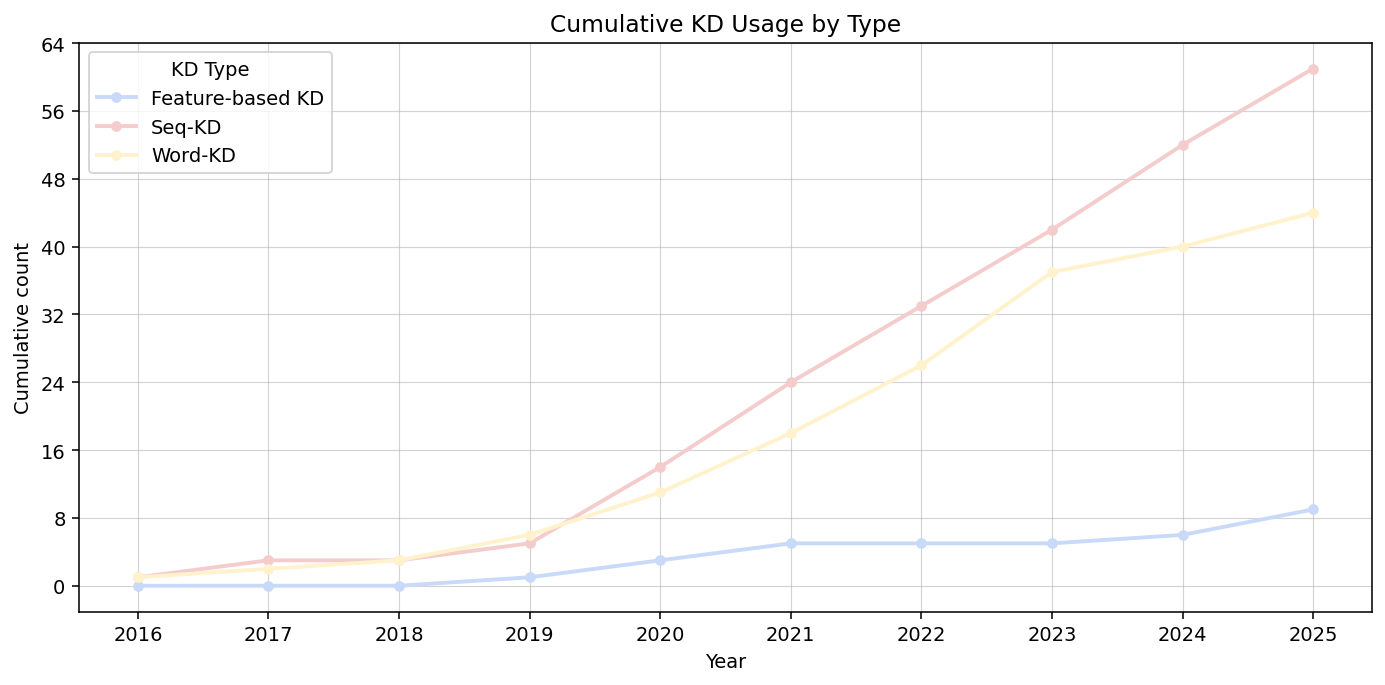

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- custom palette (hex) ---
palette = ["#C9DAF8", "#F4CCCC", "#FFF2CC"]

df = counts.copy().sort_index()

# Ensure continuous years and plain numeric types
years = range(int(df.index.min()), int(df.index.max()) + 1)
df = df.reindex(years, fill_value=0)

# Make sure columns are numeric, then cumulative
df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
cum = df.cumsum()

# Convert to NumPy for plotting (avoids multi-d indexing error)
x = pd.Index(cum.index, dtype="int64").to_numpy()

fig, ax = plt.subplots(figsize=(10, 5))
for i, c in enumerate(cum.columns):
    y = cum[c].to_numpy(dtype="float64")
    ax.plot(
        x, y,
        marker="o",
        linewidth=2,
        markersize=4.5,
        label=c,
        color=palette[i % len(palette)]
    )

ax.set_xlabel("Year")
ax.set_ylabel("Cumulative count")
ax.set_title("Cumulative KD Usage by Type")
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.grid(True, linewidth=0.6, alpha=0.55)
ax.legend(title="KD Type", loc="upper left")
plt.tight_layout()
plt.show()


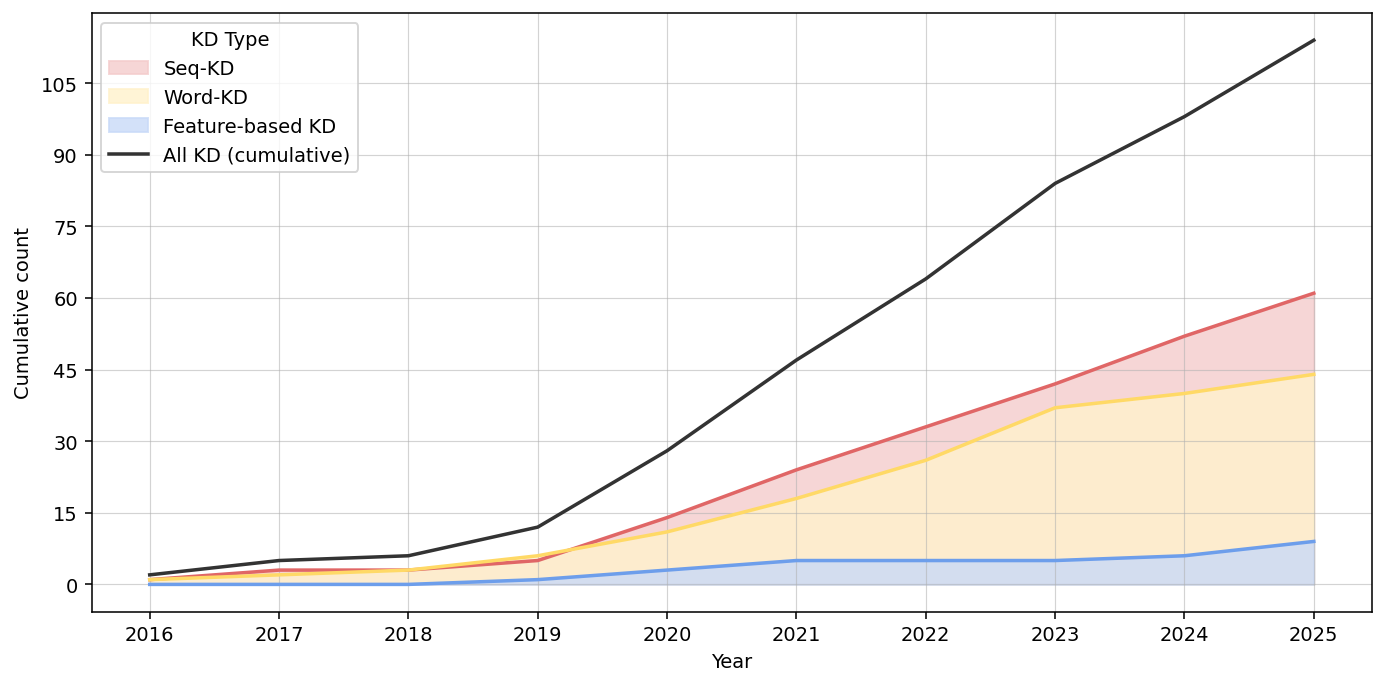

In [68]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# --- custom palette (hex) for the three KD types ---
palette = ["#C9DAF8", "#F4CCCC", "#FFF2CC"]
palette_2 = ["#6D9EEB", "#E06666", "#FFD966"]

df = counts.copy().sort_index()

# Ensure continuous years and numeric types
years = range(int(df.index.min()), int(df.index.max()) + 1)
df = df.reindex(years, fill_value=0).apply(pd.to_numeric, errors="coerce").fillna(0)

# Columns to include in "ALL KD METHODS" (exclude things like "Other")
colmap = {c.lower().strip(): c for c in df.columns}
need = ["feature-based kd", "seq-kd", "word-kd"]
missing = [k for k in need if k not in colmap]
if missing:
    raise ValueError(f"Missing expected columns (case-insensitive): {missing}")
kd_cols = [colmap[k] for k in need]

# Cumulative per series and total
cum = df[kd_cols].cumsum()
total_cum = df[kd_cols].sum(axis=1).cumsum()

# Prepare arrays
X = cum.index.to_numpy(dtype="int64")

# Plot largest last value first to reduce occlusion
order = np.argsort([cum[c].iloc[-1] for c in kd_cols])[::-1]  # largest -> smallest

fig, ax = plt.subplots(figsize=(10, 5))

for idx in order:
    c = kd_cols[idx]
    y = cum[c].to_numpy(dtype="float64")
    ax.fill_between(X, y, step=None, alpha=0.8, color=palette[idx % len(palette)], label=c)
    ax.plot(X, y, color=palette_2[idx % len(palette)],linewidth=1.8)

# Overlay cumulative total across the three KD methods
ax.plot(
    X,
    total_cum.to_numpy(dtype="float64"),
    label="All KD (cumulative)",
    linewidth=1.8,
    color="#333333",
)

ax.set_xlabel("Year")
ax.set_ylabel("Cumulative count")
#ax.set_title("Cumulative KD Usage by Type (Unstacked Area) + Total")
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.grid(True, linewidth=0.6, alpha=0.55)

# Put the total line first in the legend
handles, labels = ax.get_legend_handles_labels()
if labels and labels[-1] == "All KD Methods":
    handles = [handles[-1]] + handles[:-1]
    labels  = [labels[-1]]  + labels[:-1]
ax.legend(handles, labels, title="KD Type", loc="upper left")

plt.tight_layout()
plt.savefig('timeline.png')
plt.show()

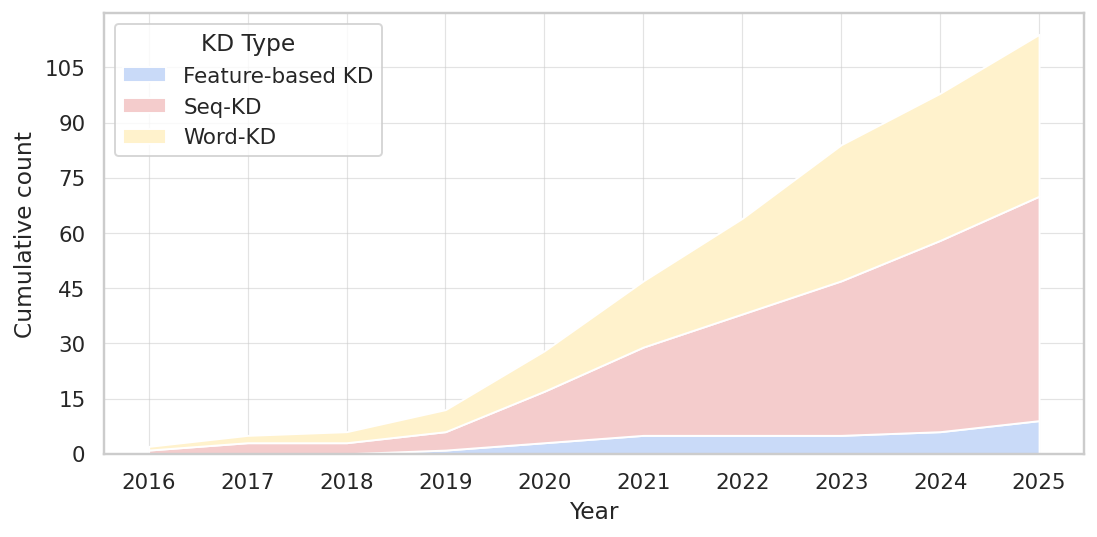

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import re
import seaborn as sns
import numpy as np
from matplotlib import rc

# --- stronger palette (same hues, more intense) ---
palette = ["#C9DAF8", "#F4CCCC", "#FFF2CC"]
# Set font to Computer Modern-like
rc('font', family='serif', serif=['CMU Serif'])
df = counts.copy().sort_index()

# Ensure continuous years and numeric types
years = range(int(df.index.min()), int(df.index.max()) + 1)
df = df.reindex(years, fill_value=0).apply(pd.to_numeric, errors="coerce").fillna(0)

# Keep only the three KD series (exclude "Other")
colmap = {c.lower().strip(): c for c in df.columns}
kd_cols = [colmap[k] for k in ["feature-based kd", "seq-kd", "word-kd"] if k in colmap]

# CUMULATIVE stacked area
cum = df[kd_cols].cumsum()

X = cum.index.to_numpy()
Y = [cum[c].to_numpy(dtype="float64") for c in kd_cols]

fig, ax = plt.subplots(figsize=(8, 4))
ax.stackplot(X, Y, labels=kd_cols, colors=palette[:len(kd_cols)])

ax.set_xlabel("Year")
ax.set_ylabel("Cumulative count")
#ax.set_title("Cumulative KD Usage by Type (Stacked Area)")
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.grid(True, linewidth=0.6, alpha=0.55)
ax.legend(title="KD Type", loc="upper left")

plt.tight_layout()
plt.savefig('timeline.pdf')

plt.show()


In [75]:
df

kd,Feature-based KD,Seq-KD,Word-KD
2016,0,1,1
2017,0,2,1
2018,0,0,1
2019,1,2,3
2020,2,9,5
2021,2,10,7
2022,0,9,8
2023,0,9,11
2024,1,10,3
2025,3,9,4


In [77]:
cum

kd,Feature-based KD,Seq-KD,Word-KD
2016,0,1,1
2017,0,3,2
2018,0,3,3
2019,1,5,6
2020,3,14,11
2021,5,24,18
2022,5,33,26
2023,5,42,37
2024,6,52,40
2025,9,61,44
